# Progettino AQM

# Alla ricerca dell' autovalore dell'hamiltoniana dello stato fondamentale

#### Autori:
Dott. Michele Grossi<br>
Francesco De Luca<br>
Ian Gremese<br>
Carlo Zollo

### Armamentario generale, da caricare prima delle diverse operazioni

#### Diagonalizzazione computazionale "classica"

Codice funzionale alla compilazione delle hamiltoniane da diagonalizzare.

In [4]:
from qiskit.quantum_info.operators import Operator, Pauli

Xp = Operator(Pauli('X'))
Zp = Operator(Pauli('Z'))
Yp = Operator(Pauli('Y'))
Id = Operator(Pauli('I'))

Funzione per la diagonalizzazione classica di una lista di lunghezza variabile di operatori $\hat H$, che ha la forma `([H0, H1, H2, ...], )`.

In [5]:
import numpy as np
from numpy import linalg

def class_par_H_diagonalizer(*H):
    E_l = []
    P_l = []
    Eivals = []
    GSvals = []
    num_qubits = 2

    for k in H[0]: #H is ([H0, H1, ...],), so Hj can be selected as H[0][j]
        E_l, P_l = linalg.eig(k.data)
        E_l = np.real(E_l)
        Eivals.append(np.sort(E_l))
        GSvals.append(np.min(E_l))
        
    return GSvals, Eivals

Funzione per il grafico dei soli valori della diagonalizzazione classica.

In [6]:
import matplotlib.pyplot as plt

def plot_class(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(9,6), dpi=100)#, fontsize=8)

    plt.xticks(B)

    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)

    ax.set(xlabel='B field', ylabel='Energy', title='')

    ax.grid()
    plt.show()

#### Diagonalizzazione quantistica con il VQE

Codice per la scrittura delle hamiltoniane da diagonalizzare:

In [7]:
import numpy as np
from numpy import linalg
from qiskit.opflow import X, Y, Z, I, primitive_ops

Funzione che cerca il minimo autovalore dell'hamiltoniana:

In [8]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
from qiskit.algorithms import VQE

def VQE_par_H_diagonalizer(local_vqe,*H):
    
    GSvals = []
    meanerr = []
    
    for i in range(len(H[0])):
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(i+1,len(H[0])))
    
        local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
        GSvals.append(np.real(local_result.eigenvalue))
        
        meanerr.append(intermediate_info['stddev'][-1])
    
    ipd_clear(wait=True)
    ipd_display("Finito.")
    return GSvals, meanerr

Funzione per la raccolta di dati relativi all'ottimizzazione del VQE:

In [9]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [10]:
#import matplotlib as mpl
#mpl.rcParams.update({'font.family': 'Linux Libertine', 'text.latex.preamble': r'\usepackage{lmr}',})

Funzione per il grafico dei valori della diagonalizzazione classica e quantistica:

In [11]:
import matplotlib.pyplot as plt

def plot_tot(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(9,6), dpi=100)

    plt.xticks(B)

    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)
    
    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.scatter(B, lists[i], marker='x')

    ax.set(xlabel='B field', ylabel='Energy', title='')

    ax.grid()
    plt.show()

## Hamiltoniana n. 2: Interazioni anisotrope fra spin in campo magnetico $B$

$$\hat H = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat X^{(i)}\hat X^{(j)} + g_y\hat Y^{(i)}\hat Y^{(j)} + g_z\hat Z^{(i)}\hat Z^{(j)} \right) - B \sum_{i=1}^n Z^{(i)}$$

### Valori dei parametri
Definiamo i valori dei parametri presenti nell'espressione dell'hamiltoniana:

In [83]:
Natoms = 4
J = -2.
gy = 0.5
gz = 0.
B = np.linspace(-180,1.8,7).tolist()

### Diagonalizzazione computazionale "classica"

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di B:

In [84]:
import numpy as np
from qiskit.opflow import X, Y, Z, I

def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction
    
    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field=(field^I)+(B*((I^i)^Z))
        spin=spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(1,i):
            spin += ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin += (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            spin += (J*gz*((I^j)^Z^(I^(i-j-1))^Z))
            
    return(spin+field)

In [85]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

In [86]:
#cH = []
#for k in B:
#    cH.append(J * (Xp.tensor(Xp) + gy*Yp.tensor(Yp) +gz* Zp.tensor(Zp)) +\
#        k * (Zp.tensor(Id) + Id.tensor(Zp)))

#### Algoritmo

Invochiamo la funzione per la diagonalizzazione classica computazionale:

In [87]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

Visualizziamo il grafico degli autovalori determinati classicamente:

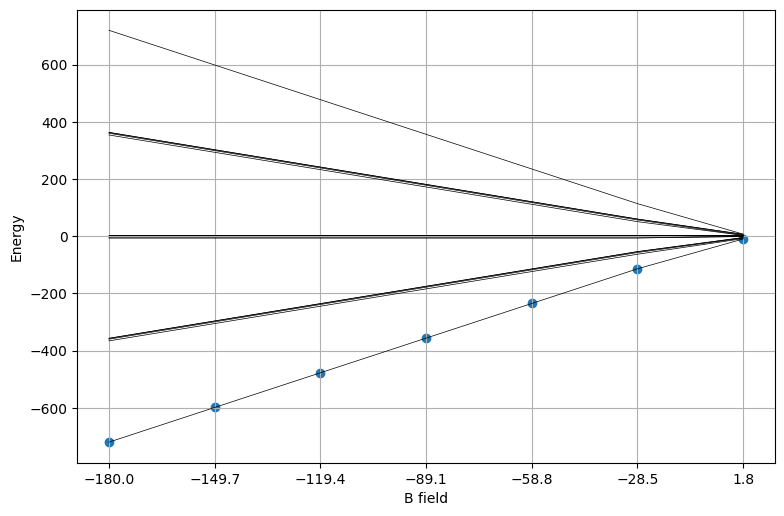

In [88]:
plot_class([cGSEigE, EigE])

### Diagonalizzazione quantistica con il VQE

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di B:

In [96]:
def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction
    
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field += primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins += primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins += primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)
            spins += primitive_ops.PauliOp(Pauli('I'*j+'Z'+'I'*(i-j-1)+'Z'+'I'*(Natoms-i-1)),J*gz)
    return (field+spins),Operator((field+spins).to_matrix())

In [97]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

#### Algoritmo

Facciamo una scelta dell'ansatz, fra `EfficientSU2` ecc., impostandone i parametri secondo la definizione che abbiamo dato al nostro problema.

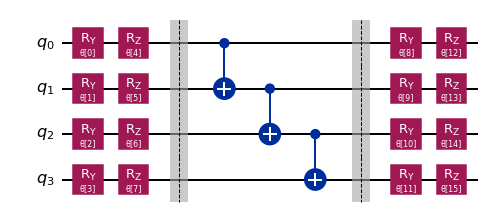

In [108]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

Scegliamo l'ottimizzatore per il VQE fra `SPSA`, `COBYLA` ecc.: 

In [109]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

Costruiamo la funzione per il VQE con ansatz, ottimizzatore, stato iniziale, "quantum instance" e funzione di callback scelti e facciamo eseguire il VQE con i parametri scelti:

In [110]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

qGSEigE, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

Visualizzo stime delle energie dei GS e stime degli errori:

In [111]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-622.259765625 5.606119633477742
-591.9078125000001 1.484334734721921
-428.42617187499997 3.4071095473799473
-344.60390624999997 1.4417325949363278
-233.80234374999995 0.4305076200794412
-113.20800781250001 0.295174545720153
-6.928906249999999 0.24126924064975094


Visualizzo il grafico con i risultati classici e della VQE:

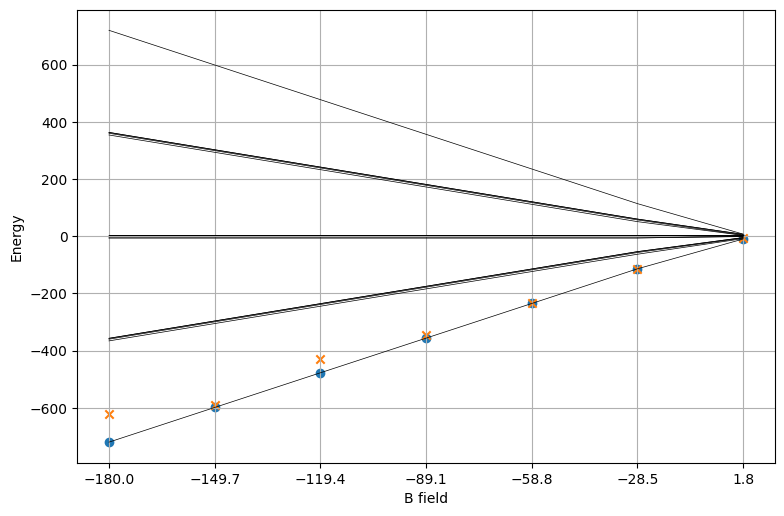

In [112]:
plot_tot([cGSEigE, EigE, qGSEigE])

### Caso con N atomi

Riproviamo come prima con più atomi

In [19]:
cH = []
Natoms=6
J = -2.
gy = 0.5
gz = 0.
B = np.linspace(-1.8,1.8,15).tolist()
for k in B:
    cH.append(Spin_Magnet_Hamilton(Natoms,J,gy,gz,k))

Sembra che in class_par_H_diagonalizer k.data estragga la matrice sia che sia fatta con opflow sia che sia fatta con la libreria Pauli_operators e quindi funziona comunque

In [20]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

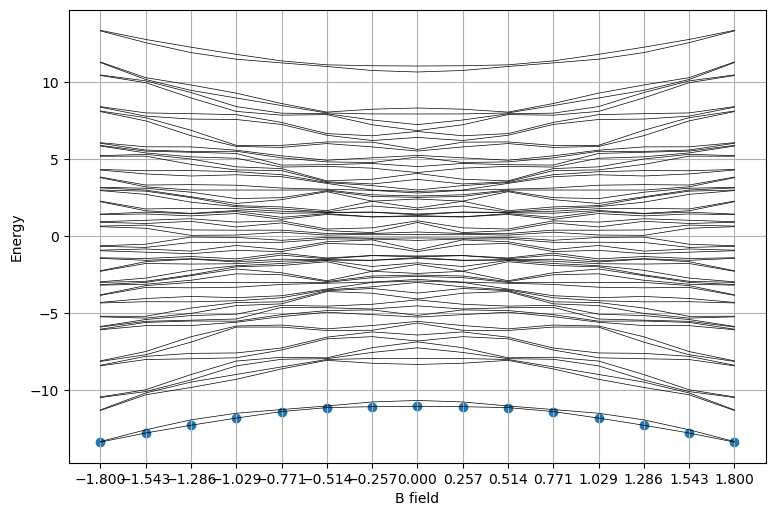

In [21]:
plot_class([cGSEigE, EigE])

In [22]:
qH = []
J = -2.
gy = 0.5
gz = 0.
B = np.linspace(-1.8,1.8,15).tolist()
    
for k in B:
    qH.append(Spin_Magnet_Hamilton(Natoms,J,gy,gz,k))

Ora proviamo a vedere se riusciamo a fare vqe. Prima in locale poi con il runtime (Sui simulatori/Hardware vero dell'IBM)

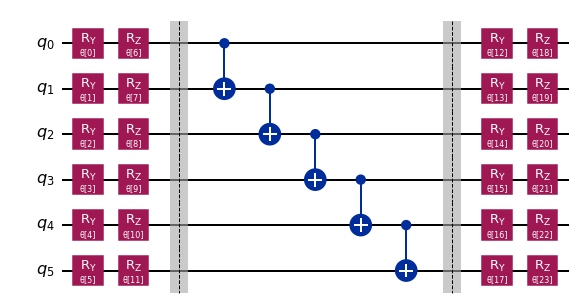

In [38]:
from qiskit.circuit.library import EfficientSU2

num_qubits = Natoms
# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

In [24]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

## Local VQE

Inizializziamo con QasmSimulatorPy, il simulatore locale della vqe. 

In [25]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [26]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
from qiskit.algorithms import VQE

def VQE_par_H_diagonalizer_Operator(local_vqe,*H):
    
    GSvals = []
    meanerr = []
    
    for i in range(len(H)):
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(i+1,len(H)))
    
        local_result = local_vqe.compute_minimum_eigenvalue(H[i])
        GSvals.append(np.real(local_result.eigenvalue))
        
        meanerr.append(intermediate_info['stddev'][-1])
        
    return GSvals, meanerr

In [27]:
print(qH[1])

Operator([[-9.25714286+0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j, -6.17142857+0.j, -3.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j, -3.        +0.j, -6.17142857+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            6.17142857+0.j, -3.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
           -3.        +0.j,  6.17142857+0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  9.25714286+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2))


qH è del tipo Operator, costruiti con opflow e teoricamente non dovrebbe dare problemi con il local_vqe però li da. Proviamo a vedere se con hamiltoniane più semplici non ci sono problemi

### Esempio Locale che funziona
preso da https://qiskit.org/documentation/partners/qiskit_runtime/tutorials/vqe.html

In [41]:
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

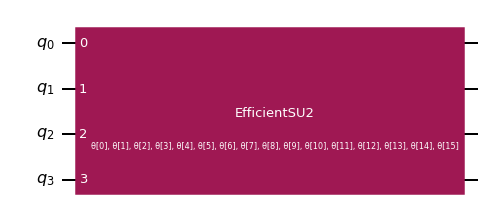

In [42]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True)
ansatz.draw('mpl', style='iqx')

Per qualche motivo a me (Francesco) disegna solo un grosso rettangolone con sopra scritto EfficientSU2, senza barriere, operatori di singolo qubit etc etc. Secondario ma boh


In [30]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [31]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [32]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [33]:
local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

In [34]:
print('Eigenvalue:', local_result.eigenvalue)


Eigenvalue: (-0.9921875+0j)


In [35]:
hamiltonian


PauliOp(Pauli('ZZII'), coeff=1.0)

La VQE locale funziona e non da problemi. hamiltoniana è però del tipo PauliOp, non Operator. Bisogna provare a convertire anche la nostra?